In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno

In [27]:
train_path = '../input/playground_series_s3e22/train.csv'
test_path = '../input/playground_series_s3e22/test.csv'
origin_path = '../input/playground_series_s3e22/horse.csv'
sample_sub_path = '../input/playground_series/input/sample_submission.csv'

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [30]:
train_df = pd.read_csv(train_path, index_col='id')
test_df = pd.read_csv(test_path, index_col='id')
origin_df = pd.read_csv(origin_path)
train_df.head(1)

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.5,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died


In [31]:
print(f'The shape of training set is {train_df.shape}.')
print(f'The shape of testing set is {test_df.shape}.')
print(f'The shape of orginal set is {origin_df.shape}.')

The shape of training set is (1235, 28).
The shape of testing set is (824, 27).
The shape of orginal set is (299, 28).


In [9]:
# what are the possible outcomes?
train_df.outcome.value_counts()

lived         574
died          410
euthanized    251
Name: outcome, dtype: int64

<Axes: >

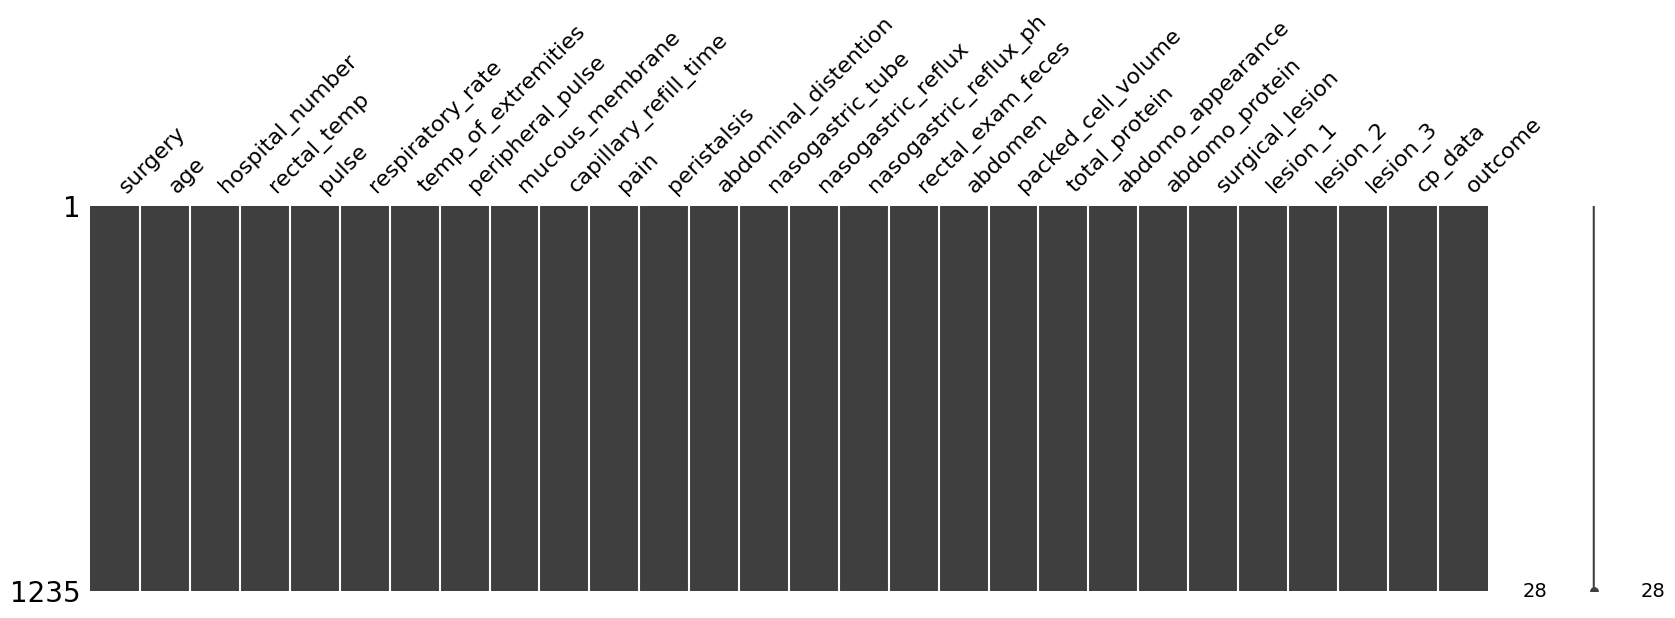

In [21]:
# missing values of training set
missingno.matrix(train_df, figsize=(20, 5))

<Axes: >

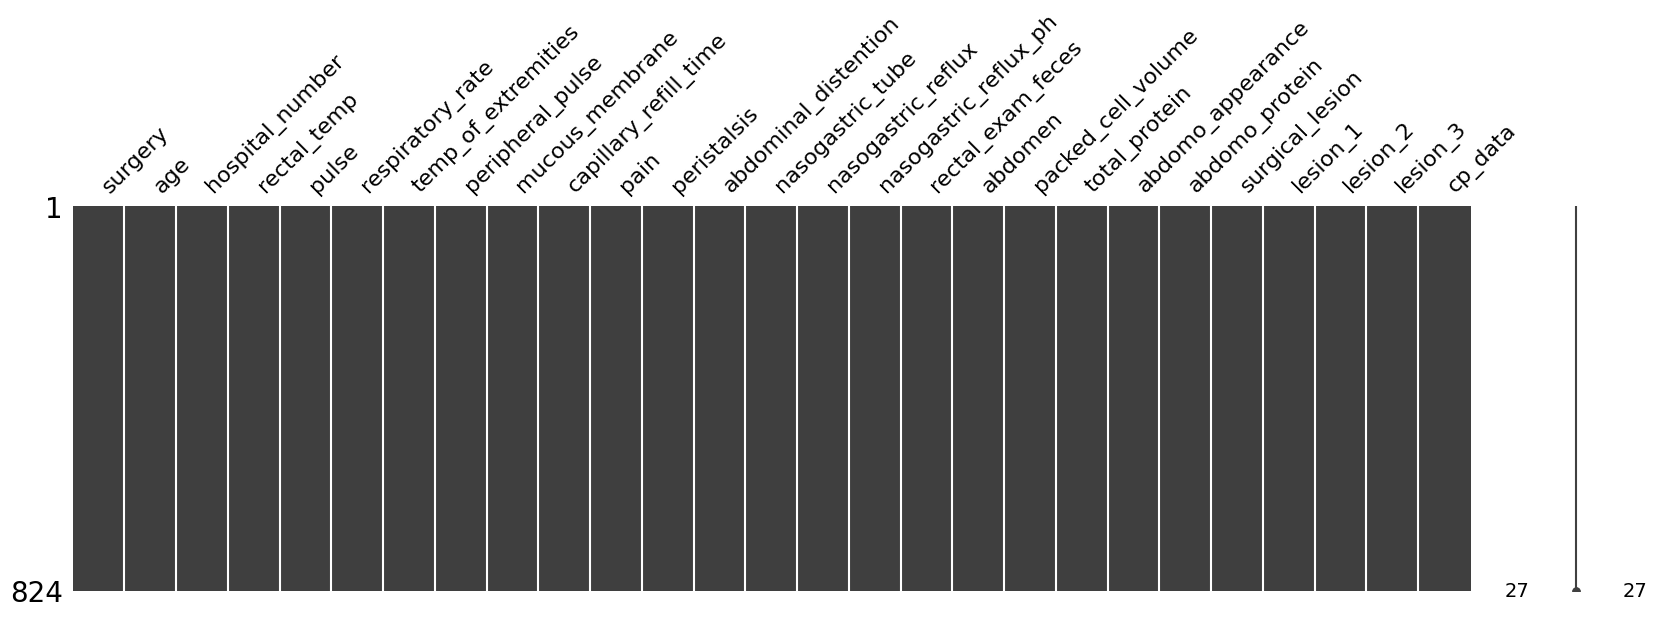

In [22]:
# issing values of testing set
missingno.matrix(test_df, figsize=(20, 5))

In [17]:
num_cols = [col for col in train_df.select_dtypes(include=['float', 'int']).columns]
cat_cols = [col for col in train_df.columns if col not in num_cols and col not in ['outcome']]

In [41]:
train_df['set'] = 'train'
test_df['set'] = 'test'
all_df = pd.concat([train_df, test_df])
print(f'The shape of all data set is {all_df.shape}.')

The shape of all data set is (2059, 29).


<Axes: >

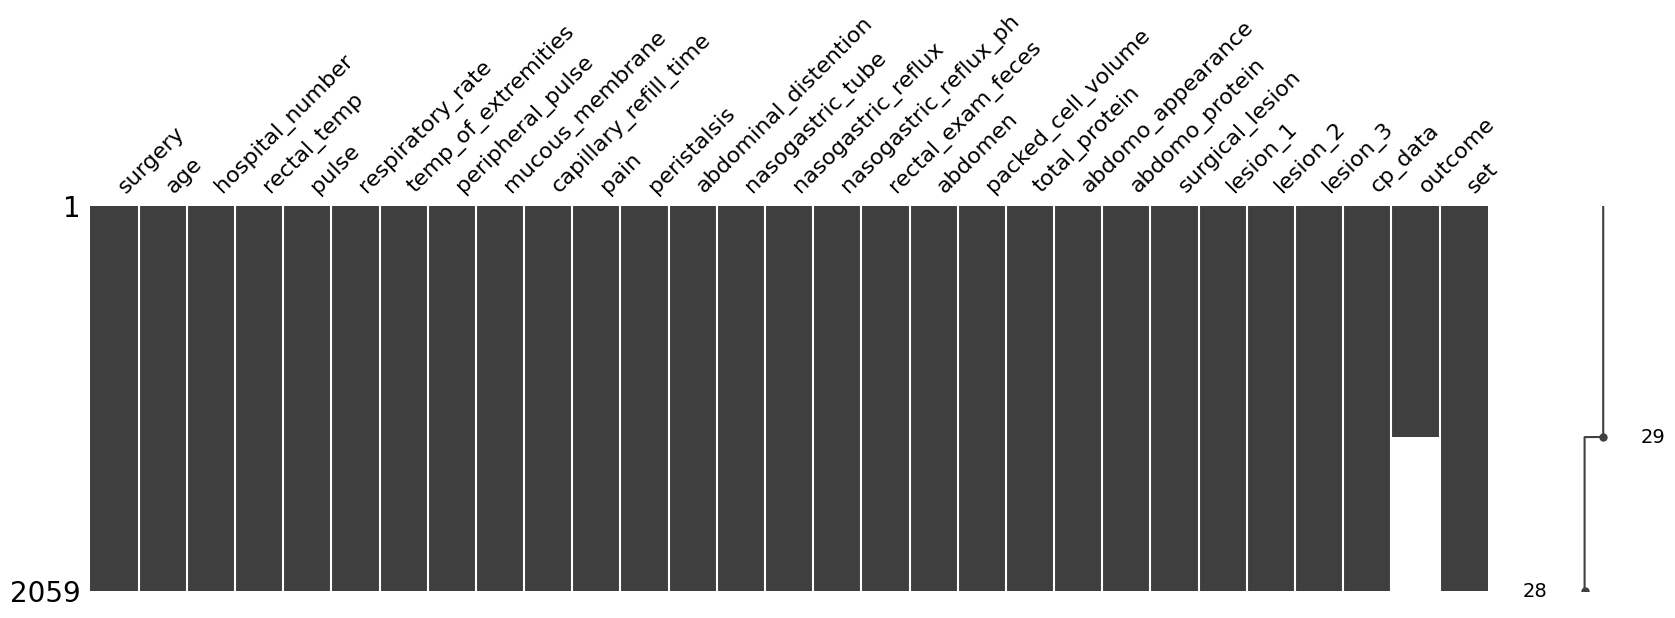

In [42]:
missingno.matrix(all_df, figsize=(20, 5))

In [18]:
print(f'There are {len(num_cols)} numeric features.')

There are 11 numeric features.


### Distribution of numeric features

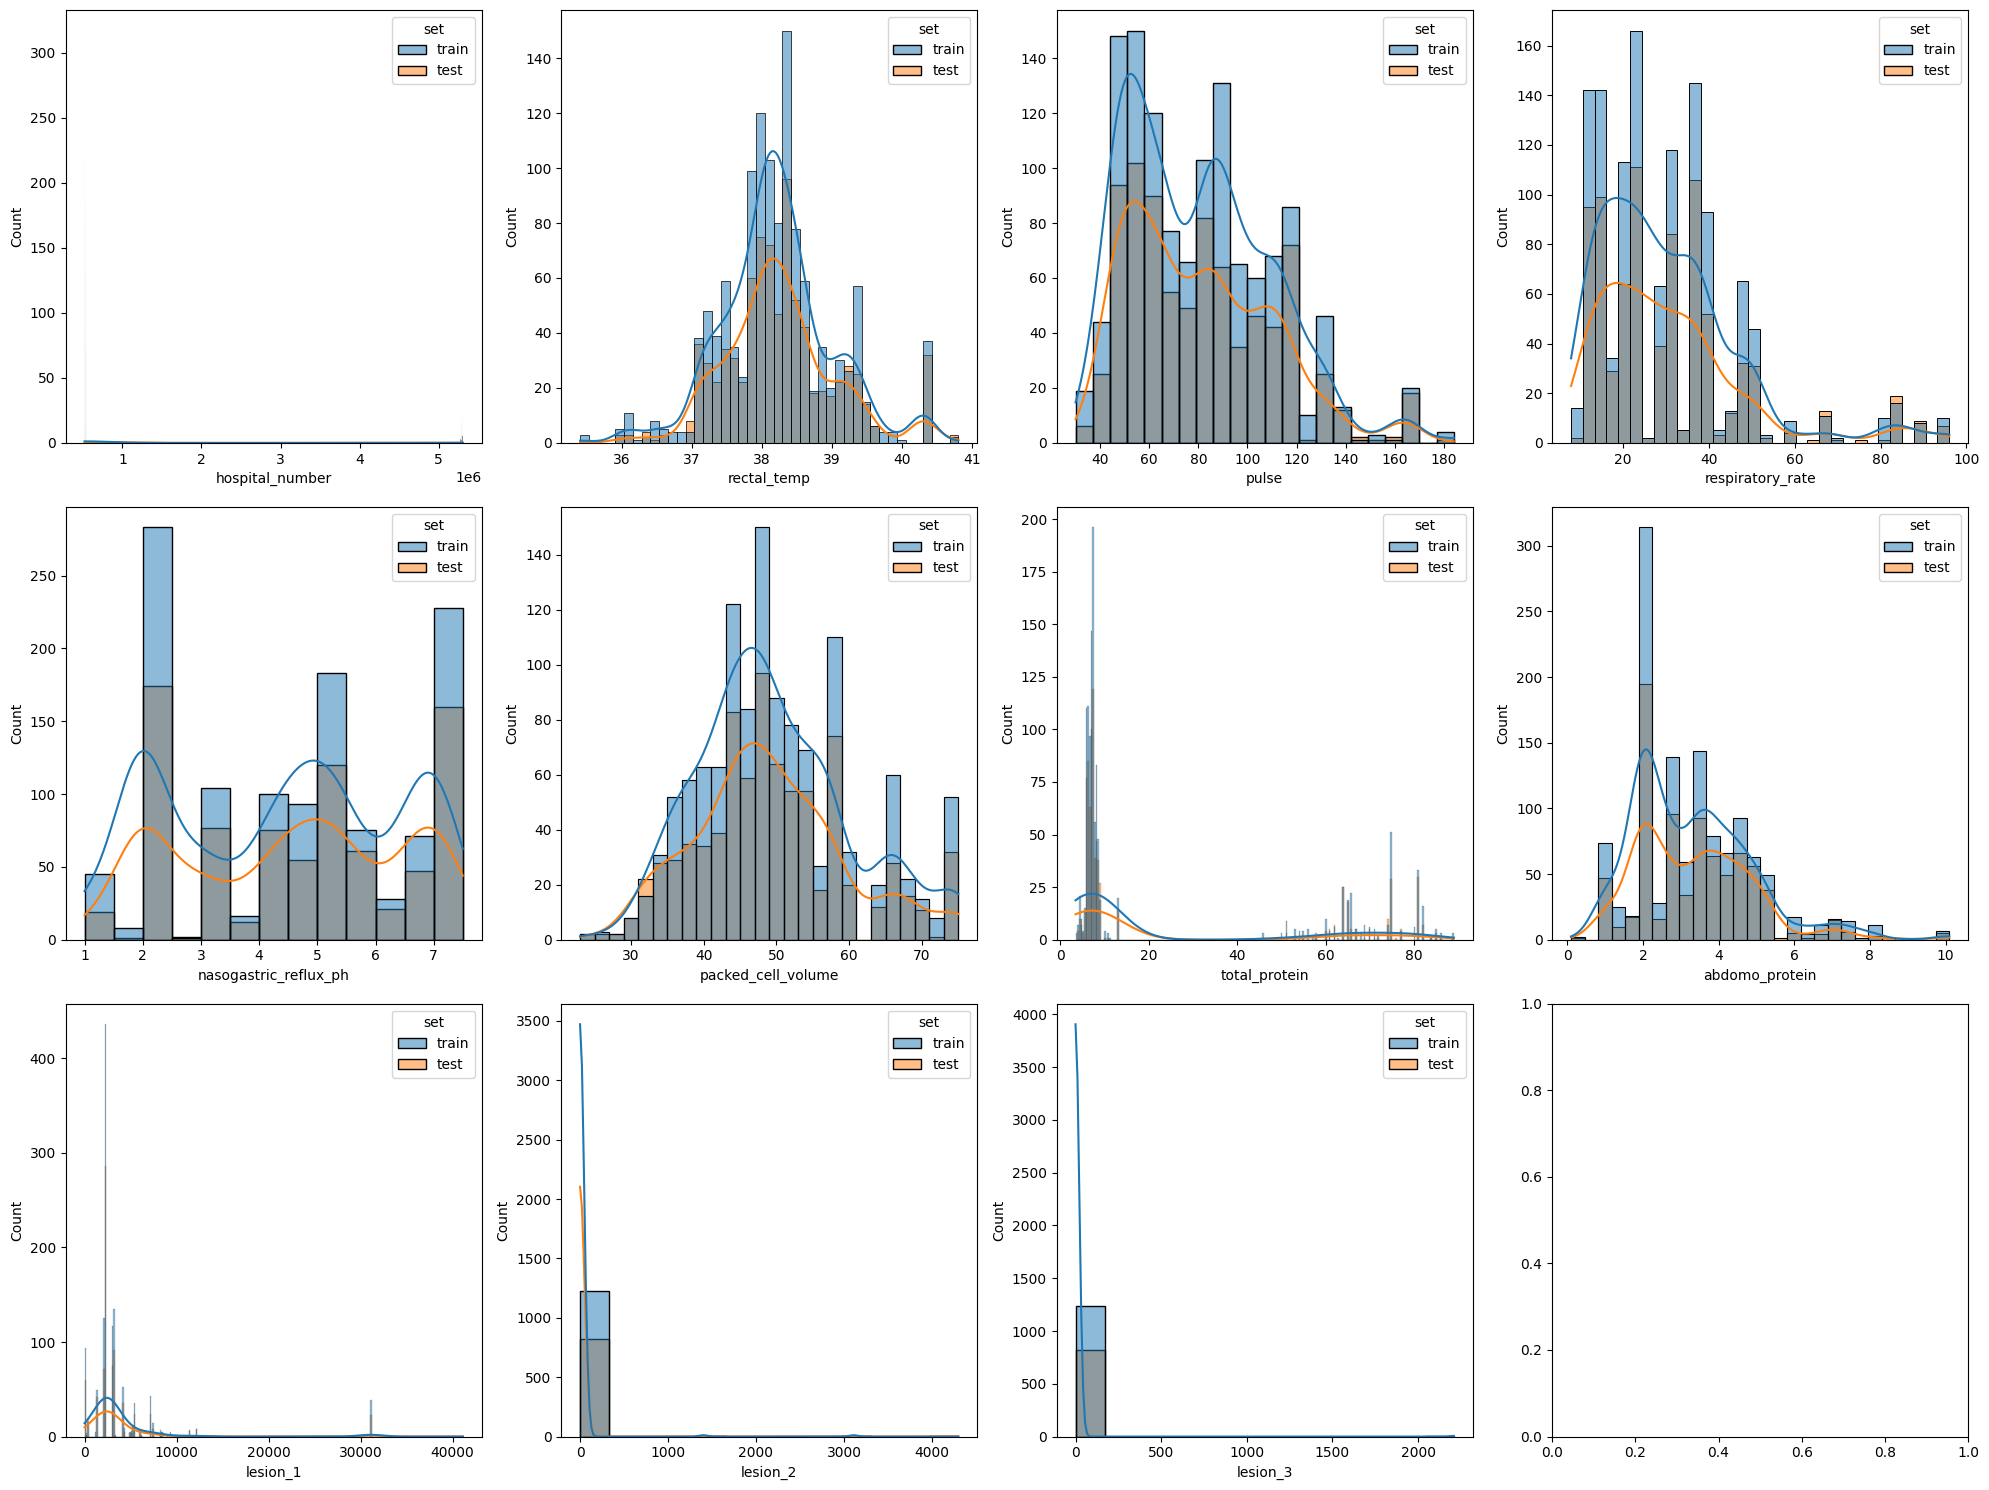

In [45]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data=all_df, x=col,  
                 kde=True, hue='set', ax=axes[i])
    
plt.tight_layout()
plt.show()

#### hospital number

In [47]:
# replace hospital number with the number of treatment
treat_num = all_df.groupby(by='hospital_number').agg({'surgery': 'count'})
treat_num = treat_num.reset_index()
treat_num = treat_num.rename(columns={'surgery': 'treat_num'})
all_df = pd.merge(all_df, treat_num, on='hospital_number', how='left')
all_df.shape

(2059, 30)

In [58]:
all_df.groupby(by='outcome').agg({'treat_num': 'mean'})

,treat_num
outcome,
died,21.670732
euthanized,15.250996
lived,15.428571


#### rectal temperature

In [52]:
# the normal temperature is around 37.8 (37.6, 38.0)
all_df['normal_temp'] = np.where((all_df.rectal_temp <= 38.0) & 
                                 (all_df.rectal_temp >= 37.6), 1, 0)

In [55]:
all_df.groupby(by='outcome').agg({'normal_temp': 'mean'})

,normal_temp
outcome,
died,0.207317
euthanized,0.243028
lived,0.229965


#### pulse

In [53]:
# the normal pulse is between 30 and 40
all_df['normal_pulse'] = np.where((all_df.pulse <= 40) &
                                  (all_df.pulse >= 30), 1, 0)

In [56]:
all_df.groupby(by='outcome').agg({'normal_pulse': 'mean'})

,normal_pulse
outcome,
died,0.017073
euthanized,0.067729
lived,0.040070


#### respiratory rate

In [54]:
# the normal respiratory rate is between 8 and 10
all_df['normal_rate'] = np.where((all_df.respiratory_rate <= 10) &
                                 (all_df.respiratory_rate >= 8), 1, 0)

In [57]:
all_df.groupby(by='outcome').agg({'normal_rate': 'mean'})

,normal_rate
outcome,
died,0.007317
euthanized,0.000000
lived,0.019164


#### nasogastric reflux ph

In [59]:
# the normal ph values are between 3 and 4
all_df['normal_ph'] = np.where((all_df.nasogastric_reflux_ph <= 4) & 
                               (all_df.nasogastric_reflux_ph >= 3), 1, 0)

In [60]:
all_df.groupby(by='outcome').agg({'normal_ph': 'mean'})

,normal_ph
outcome,
died,0.156098
euthanized,0.039841
lived,0.188153


### packed cell volume

In [61]:
# the normal cell volume is between 30 and 50
all_df['normal_cell'] = np.where((all_df.packed_cell_volume >= 30) & 
                                 (all_df.packed_cell_volume <= 50), 1, 0)
all_df.groupby(by='outcome').agg({'normal_cell': 'mean'})

,normal_cell
outcome,
died,0.529268
euthanized,0.314741
lived,0.764808
